In [1]:
%run cv.ipynb

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
Using TensorFlow backend.


In [2]:
train = pd.read_csv(input_path + '/train_data.csv', sep=',')
test = pd.read_csv(input_path + '/test_data.csv', sep=',')
train_answers = pd.read_csv(input_path + '/train_answers.csv', sep=',')

In [3]:
len(train.userId.unique()), len(test.userId.unique()), len(np.intersect1d(train.userId.unique(), test.userId.unique()))

(1357, 1192, 1001)

In [7]:
class MinMaxModel2(MyModel):
    def fit(self, train, train_answers):
        pass
    def get_base_result(self, X):
        sssdd()
        result = []
        for items in split_by(X, 'itemId'):
            x1 = items.Xmin.min()
            x2 = items.Xmax.max()
            y1 = items.Ymin.min()
            y2 = items.Ymax.max()
            itemId = items.itemId.values[0]
            result.append([itemId, x1, y1, x2, y2])
        return result      
    def get_base_result_cached(self, X):
        if self.params.get('use_cache', False):
            self.params['_predict_cache'] = self.params.get('_predict_cache', {})
            h = get_df_hash(X)
            if h in self.params['_predict_cache']:
                minmax_result = self.params['_predict_cache'][h]
            else:
                minmax_result = self.get_base_result(X)
                self.params['_predict_cache'][h] = minmax_result
        else:
            minmax_result = self.get_base_result(X)
            
        return copy.deepcopy(minmax_result)
    def predict(self, X):
        minmax_result = self.get_base_result_cached(X)
        for row in minmax_result:
            if row[1] >= 70:
                row[1] -= row[1] * self.params.get('mult')
            
        return pd.DataFrame(minmax_result, columns=['itemId', 'Xmin', 'Ymin', 'Xmax', 'Ymax']) 
#model = MinMaxModel2()
#model.fit(train, train_answers)
#print(get_score(train_answers, model.predict(train)))

In [8]:
cross_validation(MinMaxModel2({'mult':14/60.0}), train, train_answers)

KFold(n_splits=5, random_state=2707, shuffle=True)


NameError: name 'sssdd' is not defined

In [9]:
class GeneticSearchModel(MyModel):
    def __init__(self, params={}):
        self.model_class = MinMaxModelEx2
        self.params = params
        self.sub_params = {
            'use_cache': True,
        }
    def fit(self, train, train_answers):
        self.train = train
        self.train_answers = train_answers
        self.population = Population(size=self.params['size'], items=[
            MutableFloatFactory(min_value=0.2, max_value=1.5),
            MutableFloatFactory(min_value=0, max_value=0.1),
            MutableFloatFactory(min_value=0.2, max_value=1.5),
            MutableFloatFactory(min_value=0, max_value=0.7),
            MutableFloatFactory(min_value=0, max_value=0.7),
            MutableFloatFactory(min_value=50, max_value=150),
            MutableFloatFactory(min_value=8, max_value=25),
            MutableFloatFactory(min_value=8, max_value=25),
            MutableFloatFactory(min_value=0, max_value=1),
            MutableFloatFactory(min_value=0, max_value=1),
            MutableFloatFactory(min_value=5, max_value=45),
            MutableFloatFactory(min_value=5, max_value=45),
            MutableFloatFactory(min_value=5, max_value=45),
        ], score_getter=lambda x: self.score_getter(x))
        for i in range(self.params['epochs']):
            self.population.do_epoch()
        
    def set_sub_params(self, params):
        self.sub_params['mult_dx'],\
        self.sub_params['mult_dx2'],\
        self.sub_params['mult_dd'],\
        self.sub_params['mult_dd2'],\
        self.sub_params['mult_dd3'],\
        self.sub_params['thr1'],\
        self.sub_params['thr2'],\
        self.sub_params['thr3'],\
        self.sub_params['c1'],\
        self.sub_params['c2'],\
        self.sub_params['p1'],\
        self.sub_params['p2'],\
        self.sub_params['p3']\
        = params
        
#        self.sub_params['mult_x1_sqrt'],\
#        self.sub_params['mult_x1'],\
        
    def score_getter(self, params):
        self.set_sub_params(params)
        model = self.model_class(self.sub_params)
        model.fit(self.train, self.train_answers)
        return get_score(self.train_answers, model.predict(self.train)) 
    
    def predict(self, X):
        params = self.population.get_best_values()
        self.set_sub_params(params)
        model = self.model_class(self.sub_params)
        model.fit(self.train, self.train_answers)
        return model.predict(X)

In [10]:
# genetic

class LgbModel(MyModel):
    def get_X(self, data):
        return data[self.params['feats']]
    def fit(self, data):
        lgb_train = lgb.Dataset(self.get_X(data), data['target'])
        params = self.params.copy()
        num_boost_round = params['num_boost_round']
        del params['num_boost_round']
        del params['feats']
        params['objective'] = 'fair'
        self.model = lgb.train(params, lgb_train, num_boost_round=num_boost_round)
    def predict(self, data):
        return self.model.predict(self.get_X(data))
            
class MinMaxModelEx2(MinMaxModel2):
    def fit(self, train, train_answers):
        self.x1_targeter = lambda df: ppow(df.Xmin_min - df.Xmin_true, 1.0) # сколько нужно отнять от Xmin
        
        h = get_df_hash(train)
        if self.params.get('use_cache', False):
            self.params['_fit_cache'] = self.params.get('_fit_cache', {})
            if h not in self.params['_fit_cache']:
                feats_x1 = create_df(create_features(train), train_answers, aggr=True, targeter=self.x1_targeter)
                params = {
                    'boosting_type': 'gbdt',
                    'min_data_in_leaf': 100,
                    'lambda_l2': 0.5,
                    'num_leaves': 5,
                    'learning_rate': 0.007,
                    'feature_fraction': 1,
                    'bagging_fraction': 1,
                    'bagging_freq': 1,
                    'num_boost_round': 700,
                    'verbose': 0,
                }
                model_x1 = LgbModel(dict(params, feats=['Xmin_min']))
                model_x1.fit(feats_x1)
                self.params['_fit_cache'][h] = model_x1
            else:
                model_x1 = self.params['_fit_cache'][h]
        else:
            sdsdsdsd()
            
        self.model_x1 = model_x1
    def get_base_result(self, X):
        feats_x1 = create_df(create_features(X), None, aggr=True, targeter=self.x1_targeter)

        pred = pd.DataFrame({
            'itemId': feats_x1.itemId,
            'target_x1': self.model_x1.predict(feats_x1),
        })
        assert pred.shape[0] == feats_x1.shape[0]
        
        result = []
        for items in feats_x1.join(pred.set_index('itemId'), on='itemId').itertuples():
            x1 = items.Xmin_min
            y1 = items.Ymin_min
            x2 = items.Xmax_max
            y2 = items.Ymax_max
            x1_init = x1
            if x1 >= 70:
                x1 -= items.target_x1

            result.append([items.itemId, x1, y1, x2, y2, x1_init, items.Xmax_max2 - items.Xmax_max])
        return result
        
    def predict(self, X):
        minmax_result = self.get_base_result_cached(X)
        result = []
        
        mult_dx = self.params.get('mult_dx')
        mult_dx2 = self.params.get('mult_dx2')
        mult_dd = self.params.get('mult_dd')
        mult_dd2 = self.params.get('mult_dd2')
        mult_dd3 = self.params.get('mult_dd3')
        thr1 = self.params.get('thr1')
        thr2 = self.params.get('thr2')
        thr3 = self.params.get('thr3')
        c1 = self.params.get('c1')
        c2 = self.params.get('c2')
        p1 = self.params.get('p1')
        p2 = self.params.get('p2')
        p3 = self.params.get('p3')
        
        for itemId, x1, y1, x2, y2, x1_orig, x1_delta in minmax_result:
            if x1_orig >= 70:
                x1 -= x2 * mult_dx2
            
            dx = (x2 - x1)*mult_dx
            dy = y2 - y1

            if dy > dx:
                dd = (dy - dx)
                y2 -= dd*mult_dd
                if x1 >= thr1:
                    x1 -= dd*c1
                else:
                    x2 += dd*c2
            else:
                dd = (dx - dy)
                y2 += dd*mult_dd2
                y1 -= dd*mult_dd3

            if y1 < x1*thr3:
                y2 += ((x1*thr3 - y1)/(x1*thr3)) * p1              
                y1 -= ((x1*thr3 - y1)/(x1*thr3)) * p3

            if y1 < x1*thr2:
                x1 -= ((x1*thr2 - y1)/(x1*thr2)) * p2
                
            result.append([itemId, x1, y1, x2, y2])
            
        return pd.DataFrame(result, columns=['itemId', 'Xmin', 'Ymin', 'Xmax', 'Ymax']) 

In [1661]:
seed_everything(34322)
cross_validation(GeneticSearchModel({'epochs': 170, 'size': 25}), train, train_answers)

KFold(n_splits=5, random_state=2707, shuffle=True)
Best values: 1.2978861285110646, 0.09561683010070038, 1.323214361474392, 0.17903778910519758, 0.4099381810431685, 96.31806557465738, 15.5960660265178, 21.64208802974987, 0.07468668381523691, 0.5916390342120562, 34.285195193782144, 35.6251366108434, 9.808481370393686 (score=0.47152980125415056)
Best values: 0.592917567307028, 0.03857211479442773, 0.31545036616815825, 0.4521606058800189, 0.5094060256076421, 72.45414013127271, 10.638517483784462, 15.128603093341106, 0.22889691538377, 0.21172502732456133, 39.882668533269424, 24.752325014974804, 41.16878597438768 (score=0.587935801767167)


KeyboardInterrupt: 

In [204]:
def create_features(df):
    res = df.copy()
    res['width'] = df.Xmax - df.Xmin
    res['height'] = df.Ymax - df.Ymin
    res['ratio'] = ((res.width - res.height) / (res.width + res.height)).fillna(1)
    
    to_join = []
    to_join.append(df.groupby('itemId').agg({'userId': 'count'}).rename(columns={'userId': 'usersCount'}))
    for j in to_join:
        res = res.join(j, how='left', on='itemId')
    return res
def create_df(feats, answers, aggr=True, targeter=None):
    if targeter is None:
        targeter = lambda res: res.Xmin_min - res.Xmin_true # сколько нужно отнять от Xmin
    
    item_stat = feats.groupby('itemId').agg({'Xmin': 'min'})
    item_stat.rename(columns={'Xmin': 'Xmin_item'}, inplace=True)
    
    res = feats.groupby('itemId' if aggr else ['itemId', 'userId']).apply(lambda a: pd.Series({
        'width': a.width.mean(),
        'height': a.height.mean(),
        'usersCount': a.usersCount.mean(),
        'X_range': a.Xmax.max() - a.Xmin.min(),
        'Xmin_min': a.Xmin.min(),
        'Xmin_min2': min2(a.Xmin),
        'Xmin_max': a.Xmin.max(),
        'Xmin_range': a.Xmin.max() - a.Xmin.min(),
        'Xmin_mean': a.Xmin.mean(),
        'Ymin_min': a.Ymin.min(),
        'Xmax_max': a.Xmax.max(),
        'Xmax_max2': max2(a.Xmax),
        'Ymax_max': a.Ymax.max(),
        'ratio_min': a.ratio.min(),
        'ratio_max': a.ratio.max(),
        'ratio_mean': a.ratio.mean(),
        'ratio_balance': (a.Xmax.max() - a.Xmin.min()) * 0.74 - (a.Ymax.max() - a.Ymin.min())
    }))
    res.reset_index(inplace=True)
    res = res.join(item_stat, on='itemId')
    
    if answers is not None:
        res = res.merge(answers, on='itemId')
        res['target'] = targeter(res)
        res.drop(['Xmin_true', 'Ymin_true', 'Xmax_true', 'Ymax_true'], 1, inplace=True)
    return res

create_df(create_features(train), train_answers, aggr=True).head(20)

,itemId,width,height,usersCount,X_range,Xmin_min,Xmin_min2,Xmin_max,Xmin_range,Xmin_mean,Ymin_min,Xmax_max,Xmax_max2,Ymax_max,ratio_min,ratio_max,ratio_mean,ratio_balance,Xmin_item,target
0,5,317.000000,330.000000,3.0,360.0,151.0,192.0,210.0,59.0,184.333333,914.0,511.0,510.0,1331.0,-0.134694,0.194030,-0.011730,-150.60,151,-47.0
1,10,328.666667,292.666667,3.0,355.0,72.0,95.0,96.0,24.0,87.666667,559.0,427.0,420.0,858.0,0.014925,0.094340,0.057222,-36.30,72,46.0
2,13,527.000000,363.666667,3.0,575.0,46.0,69.0,94.0,48.0,69.666667,600.0,621.0,608.0,981.0,0.134948,0.218220,0.182376,44.50,46,-187.0
3,30,177.800000,93.600000,5.0,259.0,65.0,85.0,124.0,59.0,91.400000,353.0,324.0,323.0,491.0,-0.333333,0.434903,0.180328,53.66,65,4.0
4,32,228.000000,200.833333,6.0,379.0,9.0,17.0,42.0,33.0,28.166667,279.0,388.0,387.0,884.0,0.023810,0.087770,0.062097,-324.54,9,-21.0
5,48,102.666667,70.666667,3.0,113.0,50.0,52.0,55.0,5.0,52.333333,1029.0,163.0,158.0,1103.0,0.170455,0.208556,0.183662,9.62,50,-35.0
6,64,191.333333,135.666667,3.0,222.0,22.0,26.0,30.0,8.0,26.000000,417.0,244.0,235.0,564.0,0.055351,0.218659,0.161273,17.28,22,1.0
7,78,506.500000,488.000000,4.0,568.0,49.0,75.0,120.0,71.0,85.750000,194.0,617.0,590.0,707.0,-0.050104,0.107212,0.017273,-92.68,49,45.0
8,90,348.666667,288.666667,3.0,439.0,35.0,66.0,134.0,99.0,78.333333,269.0,474.0,428.0,608.0,0.046263,0.138781,0.088740,-14.14,35,-68.0
9,118,93.000000,64.000000,3.0,141.0,47.0,48.0,168.0,121.0,87.666667,1269.0,188.0,186.0,1372.0,-1.000000,0.221239,-0.207674,1.34,47,1.0


In [318]:
(train_answers.Xmax_true - train_answers.Xmin_true).mean()

384.101802757158

In [317]:
seed_everything(34332)
cross_validation(MinMaxModelEx(), train, train_answers)

KFold(n_splits=5, random_state=2707, shuffle=True)
100/189
 0 - 1 : 0.6073, mean=0.6073
85/189
 0 - 2 : 0.6054, mean=0.6064
95/189
 0 - 3 : 0.5856, mean=0.5994
107/188
 0 - 4 : 0.5899, mean=0.5971
100/188
 0 - 5 : 0.6008, mean=0.5978
KFold(n_splits=5, random_state=2708, shuffle=True)
96/189
 1 - 1 : 0.5882, mean=0.5962
92/189
 1 - 2 : 0.5963, mean=0.5962
101/189
 1 - 3 : 0.5957, mean=0.5961
98/188
 1 - 4 : 0.6100, mean=0.5977


KeyboardInterrupt: 

In [383]:
class LgbModel(MyModel):
    def get_X(self, data):
        return data[self.params['feats']]
    def fit(self, data):
        lgb_train = lgb.Dataset(self.get_X(data), data['target'])
        params = self.params.copy()
        num_boost_round = params['num_boost_round']
        del params['num_boost_round']
        del params['feats']
        params['objective'] = 'fair'
        self.model = lgb.train(params, lgb_train, num_boost_round=num_boost_round)
    def predict(self, data):
        proba = self.model.predict(self.get_X(data))
        return proba
    
class KerasModel(MyModel):
    def get_X(self, data):
        return data[self.params['feats']].copy()
    def fit(self, data):
        params = self.params
        self.scaler = MyScaler()
        data = data.copy()
        self.scaler.fit_transform(data, inplace=True)
        X = self.get_X(data)
        y = data['target'].values
        
        model = keras.models.Sequential()
        self.model = model

        model.add(keras.layers.Dense(params['n1'], activation = "relu", input_shape=(X.shape[1], )))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.LeakyReLU())

        model.add(keras.layers.Dropout(params['dropout'], noise_shape=None, seed=1))
        model.add(keras.layers.Dense(params['n2'], activation = "relu"))
        model.add(keras.layers.BatchNormalization())
        
        if 'n3' in params:
            model.add(keras.layers.Dropout(params['dropout'], noise_shape=None, seed=1))
            model.add(keras.layers.Dense(params['n3'], activation = "relu"))
            model.add(keras.layers.BatchNormalization())

        model.add(keras.layers.Dense(1, activation = "sigmoid"))
        
        if params['verbose'] > 0:
            model.summary()
        model.compile(
            optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
            loss = "mse",
            metrics = ["mse"]
        )
        results = model.fit(
            X, y,
            epochs=params['epochs'],
            batch_size=params.get('batch_size', 1024),
            verbose=params['verbose']
        )

    def predict(self, X):
        X = self.get_X(X)
        self.scaler.transform(X, inplace=True)
        res = pd.DataFrame({'target': self.model.predict(X)[:,0]})
        self.scaler.invert_transform(res, inplace=True)
        return res.target.values
            
        
class MinMaxModelEx(MyModel):
    def fit(self, train, train_answers):
#         user_ious = defaultdict(list)
#         for row in train.join(train_answers.set_index('itemId'), on='itemId').itertuples():
#             i = intersection_over_union([row.Xmin, row.Ymin, row.Xmax, row.Ymax,
#                                          row.Xmin_true, row.Ymin_true, row.Xmax_true, row.Ymax_true])
#             user_ious[row.userId].append(i)
#         self.bad_users = [userId for userId, ious in user_ious.items() if len(ious) > 3 and np.mean(ious) < 0.3]
        
        self.x1_targeter = lambda df: ppow(df.Xmin_min - df.Xmin_true, 1.0) # сколько нужно отнять от Xmin
        self.x2_targeter = lambda df: df.Xmax_max - df.Xmax_true
#         self.x1_del_targeter = lambda df:(
#                     (df.Xmax_max > df.Xmax_true) & ((df.Xmax_max2 > df.Xmax_true) |
#                                                     (df.Xmax_max - df.Xmax_true > df.Xmax_true - df.Xmax_max2))
#                                          ).astype(np.int8)
        self.x1_del_targeter = lambda df:(
                    (df.Xmin_min < df.Xmin_true) & ((df.Xmin_min2 < df.Xmin_true) |
                                                    (df.Xmin_true - df.Xmin_min > df.Xmin_min2 - df.Xmin_true))
                                         ).astype(np.int8)
        feats_x1 = create_df(create_features(train), train_answers, aggr=True, targeter=self.x1_targeter)
        #feats_x2 = create_df(create_features(train), train_answers, aggr=True, targeter=self.x2_targeter)
        #feats_x1_del = create_df(create_features(train), train_answers, aggr=True, targeter=self.x1_del_targeter)
        params = {
            'boosting_type': 'gbdt',
            'min_data_in_leaf': 100,
            'lambda_l2': 0.5,
            'num_leaves': 5,
            'learning_rate': 0.007,
            'feature_fraction': 1,
            'bagging_fraction': 1,
            'bagging_freq': 1,
            'num_boost_round': 700,
            'verbose': 0,
        }
#         params = {
#             'epochs': 30,
#             'verbose': 0,
#             'n1': 7,
#             'n2': 7,
#             'dropout': 0.1,
#         }
        self.model_x1 = LgbModel(dict(params, feats=['Xmin_min']))
        #self.model_x1 = KerasModel(dict(params, feats=['Xmin_min', 'Ymin_min', 'Xmax_max', 'Ymax_max', 'usersCount',
        #                                              'ratio_mean']))
        self.model_x1.fit(feats_x1)
        #self.model_x2 = LgbModel(dict(params, feats=['Xmin_min', 'Xmax_max', 'Xmax_max2']))
        #self.model_x2.fit(feats_x2)
        #self.model_x1_del = LgbModel(dict(params, feats=['Xmin_min', 'Xmin_min2', 'width', 'usersCount',
        #                                                'Ymin_min', 'ratio_mean'],
        #                                 num_leaves=8))
        #self.model_x1_del.fit(feats_x1_del)
    def predict(self, X):
        #X = X[~X.userId.isin(self.bad_users)]
        feats_x1 = create_df(create_features(X), None, aggr=True, targeter=self.x1_targeter)
        #feats_x2 = create_df(create_features(X), None, aggr=True, targeter=self.x2_targeter)
        #feats_x1_del = create_df(create_features(X), None, aggr=False, targeter=self.x1_del_targeter)
#        assert all(feats_x1.itemId == feats_x2.itemId)
        pred = pd.DataFrame({
            'itemId': feats_x1.itemId,
            'target_x1': self.model_x1.predict(feats_x1),
            #'target_x2': self.model_x2.predict(feats_x2),
        })
        assert pred.shape[0] == feats_x1.shape[0]  
#         pred_no_aggr = pd.DataFrame({
#             'itemId': feats_x1_del.itemId,
#             'userId': feats_x1_del.userId,
#             'target_x1_del': self.model_x1_del.predict(feats_x1_del),
#         })
#        pred_no_aggr = pred_no_aggr.groupby('userId').agg({'target_x1_del': 'mean'}).reset_index()
        
        result = []
        a=0
        for items in feats_x1.join(pred.set_index('itemId'), on='itemId').itertuples():
            x1 = items.Xmin_min
            y1 = items.Ymin_min
            x2 = items.Xmax_max
            y2 = items.Ymax_max
            x1_orig = x1
            if x1_orig >= 70:
                x1 -= items.target_x1 + x2 / 60 * 1.2
            
            mult_dx,\
            mult_dd,\
            thr1,\
            thr2,\
            thr3,\
            c1,\
            c2,\
            p1,\
            p2 = 0.7415657456058256, 0.5640671461647451, 80.04833508987377, 17.020502776535906, 14.801316697593093, 0.06141877165368582, 0.36311996949549297, 20.650668482381576, 28.753285758777665
            
            mult_dd2 = 0.3
            p1 = 25
            
            dx = (x2 - x1)*mult_dx
            dy = y2 - y1

            if dy > dx:
                dd = (dy - dx)
                y2 -= dd*mult_dd
                if x1 >= thr1:
                    x1 -= dd*c1
                else:
                    x2 += dd*c2
            else:
                dd = (dx - dy)
                y2 += dd*mult_dd2
                y1 -= dd*0.1

            if y2 < x1*thr3:
                y2 += ((x1*thr3 - y2)/(x1*thr3)) * p1
                y1 -= ((x1*thr3 - y2)/(x1*thr3)) * 12  # wtf
                
            if y1 < x1*thr2:
                x1 -= ((x1*thr2 - y1)/(x1*thr2)) * p2
                
            if dy > 318:
                y2 -= (dy - 318) / 318 * 5
                
            v=450
            if dx/mult_dx > v:
                x2 -= (dx/mult_dx - v) / v * 10
                x1 += (dx/mult_dx - v) / v * 10
                


            result.append([items.itemId, x1, y1, x2, y2])
        print('{}/{}'.format(a, len(result)))
        return pd.DataFrame(result, columns=['itemId', 'Xmin', 'Ymin', 'Xmax', 'Ymax']) 

In [384]:
seed_everything(34332)
cross_validation(MinMaxModelEx(), train, train_answers)

KFold(n_splits=5, random_state=2707, shuffle=True)
0/189
 0 - 1 : 0.6079, mean=0.6079
0/189
 0 - 2 : 0.6071, mean=0.6075


KeyboardInterrupt: 

In [337]:
seed_everything(34332)
cross_validation(MinMaxModelEx(), train, train_answers)

KFold(n_splits=5, random_state=2707, shuffle=True)
0/189
 0 - 1 : 0.6079, mean=0.6079
0/189
 0 - 2 : 0.6071, mean=0.6075
0/189
 0 - 3 : 0.5855, mean=0.6002
0/188
 0 - 4 : 0.5911, mean=0.5979
0/188
 0 - 5 : 0.6009, mean=0.5985
KFold(n_splits=5, random_state=2708, shuffle=True)
0/189
 1 - 1 : 0.5891, mean=0.5969
0/189
 1 - 2 : 0.5981, mean=0.5971
0/189
 1 - 3 : 0.5953, mean=0.5969
0/188
 1 - 4 : 0.6098, mean=0.5983
0/188
 1 - 5 : 0.6005, mean=0.5985
KFold(n_splits=5, random_state=2709, shuffle=True)
0/189
 2 - 1 : 0.6060, mean=0.5992
0/189
 2 - 2 : 0.5996, mean=0.5992
0/189
 2 - 3 : 0.6003, mean=0.5993
0/188
 2 - 4 : 0.5980, mean=0.5992
0/188
 2 - 5 : 0.5883, mean=0.5985
KFold(n_splits=5, random_state=2710, shuffle=True)
0/189
 3 - 1 : 0.5859, mean=0.5977
0/189
 3 - 2 : 0.5947, mean=0.5975
0/189
 3 - 3 : 0.6027, mean=0.5978
0/188
 3 - 4 : 0.6178, mean=0.5989
0/188
 3 - 5 : 0.5903, mean=0.5984
KFold(n_splits=5, random_state=2711, shuffle=True)
0/189
 4 - 1 : 0.6030, mean=0.5987
0/189
 4 -

0.5984359892638411

In [142]:
qq = MinMaxModelEx()
qq.fit(train, train_answers)
sorted(qq.bad_users)

AttributeError: 'MinMaxModelEx' object has no attribute 'bad_users'

In [268]:
(train_answers.Ymax_true - train_answers.Ymin_true).mean()

318.87910922587486

In [ ]:
#0.7337833611994833, 0.499365778384406

In [343]:
seed_everything(34332)
model = MinMaxModelEx()
#model = GeneticSearchModel({'epochs': 600, 'size': 50})
model.fit(train, train_answers)
res_test = model.predict(test).sort_values(by='itemId')
res_test.head(10)

0/630


,itemId,Xmin,Ymin,Xmax,Ymax
0,18,71.045600,632.486276,758.833933,1133.096799
1,19,27.000000,559.000000,155.956880,671.591530
2,33,21.000000,378.056466,414.000000,657.830601
3,62,38.422222,823.009429,635.577778,1263.084921
4,114,35.732554,570.000000,245.131661,734.747152
5,146,13.125421,211.000000,799.871092,858.981431
6,156,54.599293,801.664922,164.270652,881.083889
7,163,17.747588,317.000000,215.040508,461.830294
8,164,4.000000,146.000000,488.366083,541.874398
9,179,58.605119,485.508718,330.000000,709.985966


In [344]:
with open(output_path + '/res.txt', 'w') as out:
    lines = res_test.apply(lambda x: '%d,%f,%f,%f,%f' % (x.itemId, x.Xmin, x.Ymin, x.Xmax, x.Ymax), axis=1).values 
    out.write('\n'.join(lines) + '\n')

In [235]:
train_answers.Xmin_true.min()

-1

In [272]:
tr = train.join(train_answers.set_index('itemId'), on='itemId')
xx = []
yy = []
for items in split_by(tr, 'itemId'):
    if items.Xmin.min() >= 70:
        xx.append(items.Xmin.min())
        yy.append(items.Xmin_true.min() - items.Xmin.min())

In [273]:
lm = LinearRegression()
lm.fit(pd.DataFrame({'x': xx}), yy)

lm.intercept_, lm.coef_


(35.39801551929624, array([-0.38744356]))

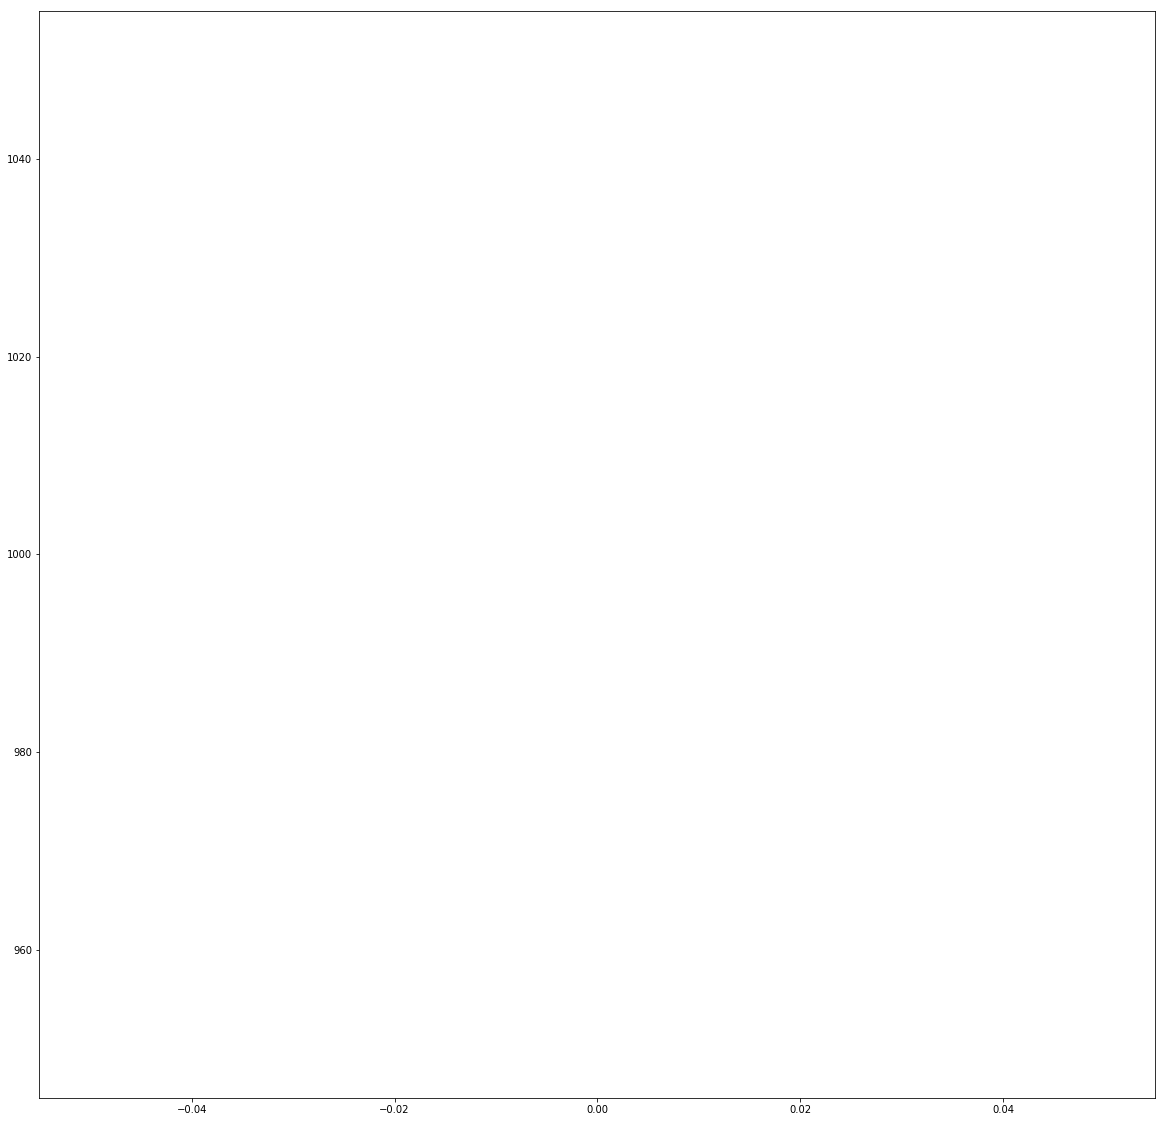

In [280]:
fig, axs = plt.subplots(1, 1, figsize=(20, 20))
axs.scatter(xx, yy)
axs.plot([0, 0], [1000, 1000], 'k-')
plt.show()

In [306]:
model = MinMaxModel()
model.fit(train, train_answers)
tr_stat = model.predict(train).merge(train_answers, on=['itemId'])
tr_stat.head()

,itemId,Xmin,Ymin,Xmax,Ymax,Xmin_true,Ymin_true,Xmax_true,Ymax_true
0,6132,39,637,276,831,47,650,213,812
1,31297,25,393,126,487,18,390,122,472
2,18168,159,718,587,1074,35,713,656,1082
3,8398,53,1019,61,1028,51,1021,59,1027
4,8774,116,959,795,1317,205,792,835,1309


In [307]:
scores = tr_stat.apply(lambda x: pd.Series([x.itemId,\
                         intersection_over_union([x.Xmin, x.Ymin, x.Xmax, x.Ymax, x.Xmin_true, x.Ymin_true, x.Xmax_true, x.Ymax_true])]\
                                 , index=['itemId', 'score']), 1)
tr_stat = tr_stat.merge(scores, on=['itemId'])

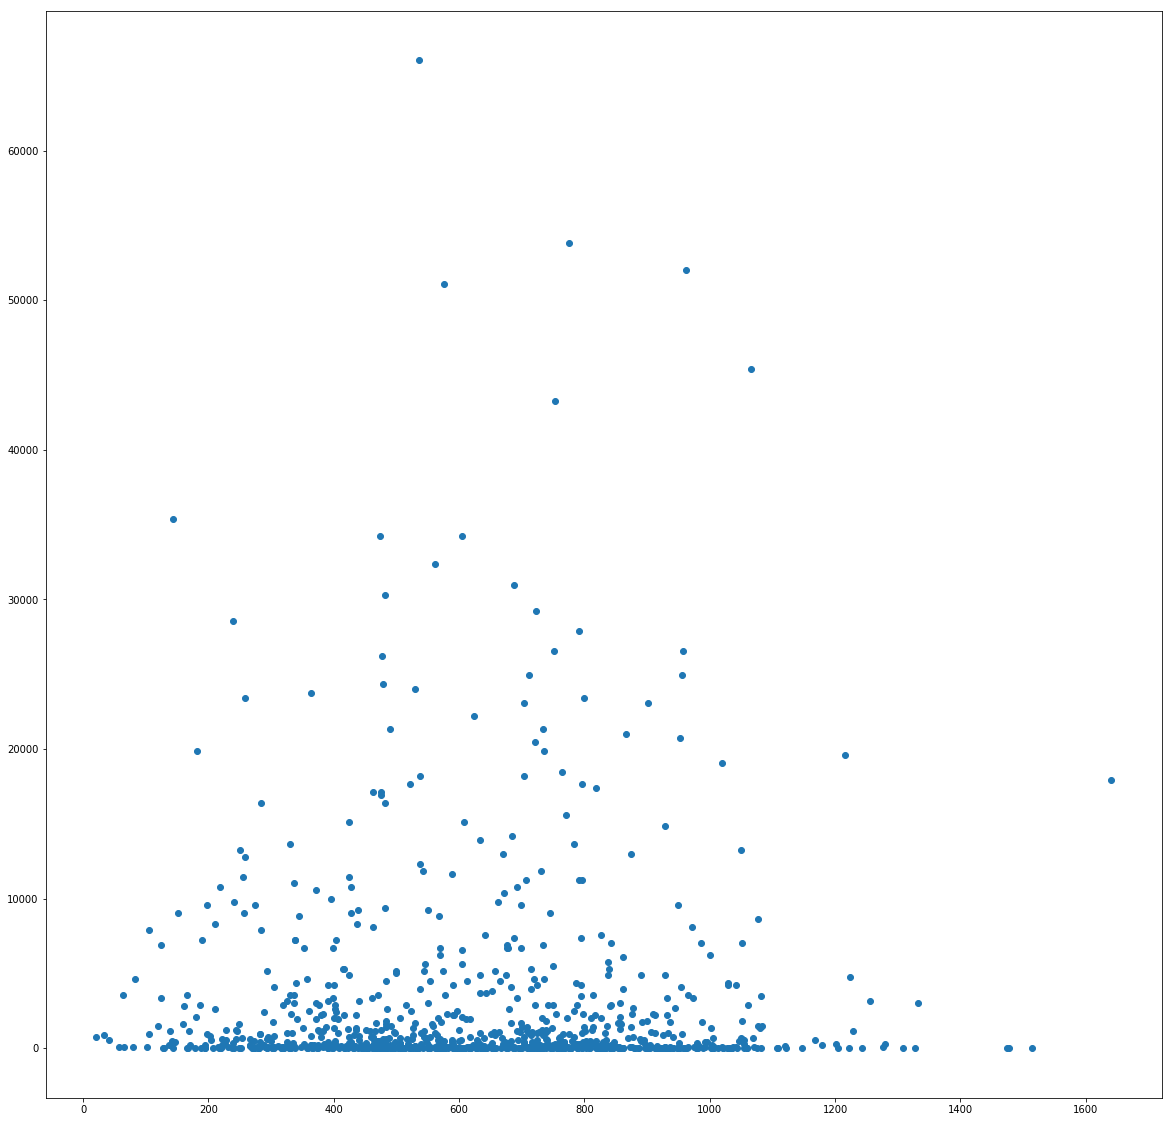

In [314]:
fig, axs = plt.subplots(1, 1, figsize=(20, 20))
axs.scatter(tr_stat.Ymin_true, (tr_stat.Ymin_true - tr_stat.Ymin)**2)
plt.show()

In [161]:
for items in split_by(train, 'itemId'):
    items = list(items.itertuples())
    items = list(map(Rect, items))
    items.sort(key=lambda a: a.x1)
    a = all(items[i - 1].contains(items[i]) for i in range(1, len(items)))
    if (a):
        print(items[0].itemId)


118
2014
5797
8374
8520
11910
13855
16332
16809
16944
17177
18713
18756
23728
25135
26967
27956
29282
31033
31749
32631
35123


In [144]:
a = list(split_by(train, 'itemId')[0].itertuples())[0]

In [147]:
str(type(a))

"<class 'pandas.core.frame.Pandas'>"

In [146]:
pd.core.frame.Pandas

AttributeError: module 'pandas.core.frame' has no attribute 'Pandas'

In [110]:
ee = []
train.groupby('itemId').apply(lambda x: ee.append(x))
ee[0]

,userId,itemId,Xmin,Ymin,Xmax,Ymax
2988,141,5,210,925,483,1255
2989,903,5,151,917,511,1160
2990,1723,5,192,914,510,1331


In [105]:
type(train)

pandas.core.frame.DataFrame

In [112]:
x1_brd = []
x2_brd = []
y1_brd = []
y2_brd = []
for items in split_by(train.join(train_answers.set_index('itemId'), on='itemId'), 'itemId'):
    itemId = items.itemId.values[0]
    rect = Rect([items.Xmin_true.values[0], items.Ymin_true.values[0], items.Xmax_true.values[0], items.Ymax_true.values[0]])
    rect.itemId = items.itemId.values[0]
    rect.userId = items.userId.values[0]
    if items.Xmin.min() == items.Xmin_true.min():
        x1_brd.append(rect)
    if items.Ymin.min() == items.Ymin_true.min():
        y1_brd.append(rect)
    if items.Xmax.max() == items.Xmax_true.max():
        x2_brd.append(rect)
    if items.Ymax.max() == items.Ymax_true.max():
        y2_brd.append(rect)
        
print(len(x1_brd), len(x2_brd), len(y1_brd), len(y2_brd))

30 24 40 31


In [131]:
','.join(map(str, list(map(lambda x: x.itemId, x1_brd)) + list(map(lambda x: x.itemId, x2_brd)) + list(map(lambda x: x.itemId, y1_brd)) + list(map(lambda x: x.itemId, y2_brd))))

'1691,4322,5312,6013,7010,9523,9813,10004,10477,10544,12016,12488,13855,15374,18374,21223,21424,22483,25135,29550,30089,30683,31033,31749,32714,32928,33357,33551,34508,34791,4117,7555,10255,10477,10867,11258,12543,13983,14575,17216,18546,18729,20558,22483,23181,25135,26374,31033,32182,32551,34362,34990,34998,35648,1095,1147,3009,4257,4752,7761,9523,13007,13855,16045,16538,17177,17190,17449,17653,18093,21231,22330,22475,22483,23031,24763,25094,25135,25142,25324,26628,26973,28987,30615,30683,31033,31086,31515,32631,32954,33665,34114,34957,35476,843,1147,3973,4408,5014,9407,10255,11212,11258,12701,13194,13386,13855,14575,15096,22391,22483,23342,23416,23609,25014,25135,25142,25324,26489,28030,28597,29498,30215,31033,34114'

In [114]:
list(map(str, x1_brd))

['Rect[14, 353]*[302, 568]',
 'Rect[23, 58]*[359, 390]',
 'Rect[48, 87]*[819, 853]',
 'Rect[48, 67]*[924, 938]',
 'Rect[15, 244]*[439, 696]',
 'Rect[48, 80]*[854, 880]',
 'Rect[59, 259]*[980, 1134]',
 'Rect[34, 240]*[636, 783]',
 'Rect[40, 121]*[719, 774]',
 'Rect[27, 111]*[552, 594]',
 'Rect[34, 50]*[709, 719]',
 'Rect[21, 631]*[321, 772]',
 'Rect[56, 62]*[1121, 1127]',
 'Rect[41, 157]*[749, 883]',
 'Rect[35, 397]*[596, 783]',
 'Rect[32, 314]*[597, 784]',
 'Rect[40, 61]*[576, 584]',
 'Rect[37, 40]*[768, 770]',
 'Rect[45, 45]*[1243, 1243]',
 'Rect[16, 534]*[342, 663]',
 'Rect[28, 310]*[428, 519]',
 'Rect[45, 123]*[1222, 1300]',
 'Rect[47, 48]*[963, 963]',
 'Rect[56, 63]*[1013, 1019]',
 'Rect[40, 151]*[753, 830]',
 'Rect[31, 46]*[846, 861]',
 'Rect[48, 263]*[897, 1058]',
 'Rect[46, 183]*[960, 1062]',
 'Rect[30, 310]*[857, 1205]',
 'Rect[49, 280]*[890, 1012]']

In [122]:
(train_answers.Xmin_true <= 59).mean()

0.5418875927889714

In [123]:
(train.Xmin <= 59).mean()

0.3509462244706764

In [105]:
str(sorted(list(map(lambda a: a[1], x1_brd))))

'[14, 15, 16, 21, 23, 27, 28, 30, 31, 32, 34, 34, 35, 37, 40, 40, 40, 41, 45, 45, 46, 47, 48, 48, 48, 48, 49, 56, 56, 59]'

In [106]:
str(sorted(list(map(lambda a: a[1], x2_brd))))

'[36, 38, 39, 43, 45, 46, 47, 54, 55, 55, 56, 61, 75, 75, 93, 95, 95, 97, 181, 206, 209, 214, 239, 299]'

In [107]:
str(sorted(list(map(lambda a: a[1], y1_brd))))

'[16, 22, 22, 23, 25, 29, 31, 32, 33, 33, 33, 35, 37, 37, 38, 40, 40, 41, 43, 43, 45, 45, 46, 47, 48, 48, 51, 52, 53, 53, 54, 55, 56, 57, 58, 60, 82, 85, 101, 103]'

In [108]:
str(sorted(list(map(lambda a: a[1], y2_brd))))

'[31, 38, 44, 45, 48, 48, 57, 58, 60, 62, 74, 79, 83, 94, 95, 98, 100, 100, 102, 105, 133, 148, 176, 177, 179, 222, 243, 260, 323, 354, 528]'

In [98]:
train_answers.shape

(943, 5)

In [110]:
sorted(train_answers.Xmin_true.unique())

[-1,
 0,
 1,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 111,
 112,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 127,
 128,
 129,
 130,
 131,
 132,
 135,
 136,
 138,
 139,
 140,
 141,
 142,
 143,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 153,
 155,
 156,
 157,
 158,
 159,
 160,
 162,
 163,
 164,
 165,
 167,
 169,
 172,
 173,
 174,
 175,
 176,
 178,
 181,
 186,
 187,
 189,
 193,
 195,
 197,
 198,
 199,
 201,
 202,
 204,
 205,
 207,
 209,
 210,
 211,
 212,
 214,
 215,
 216,
 218

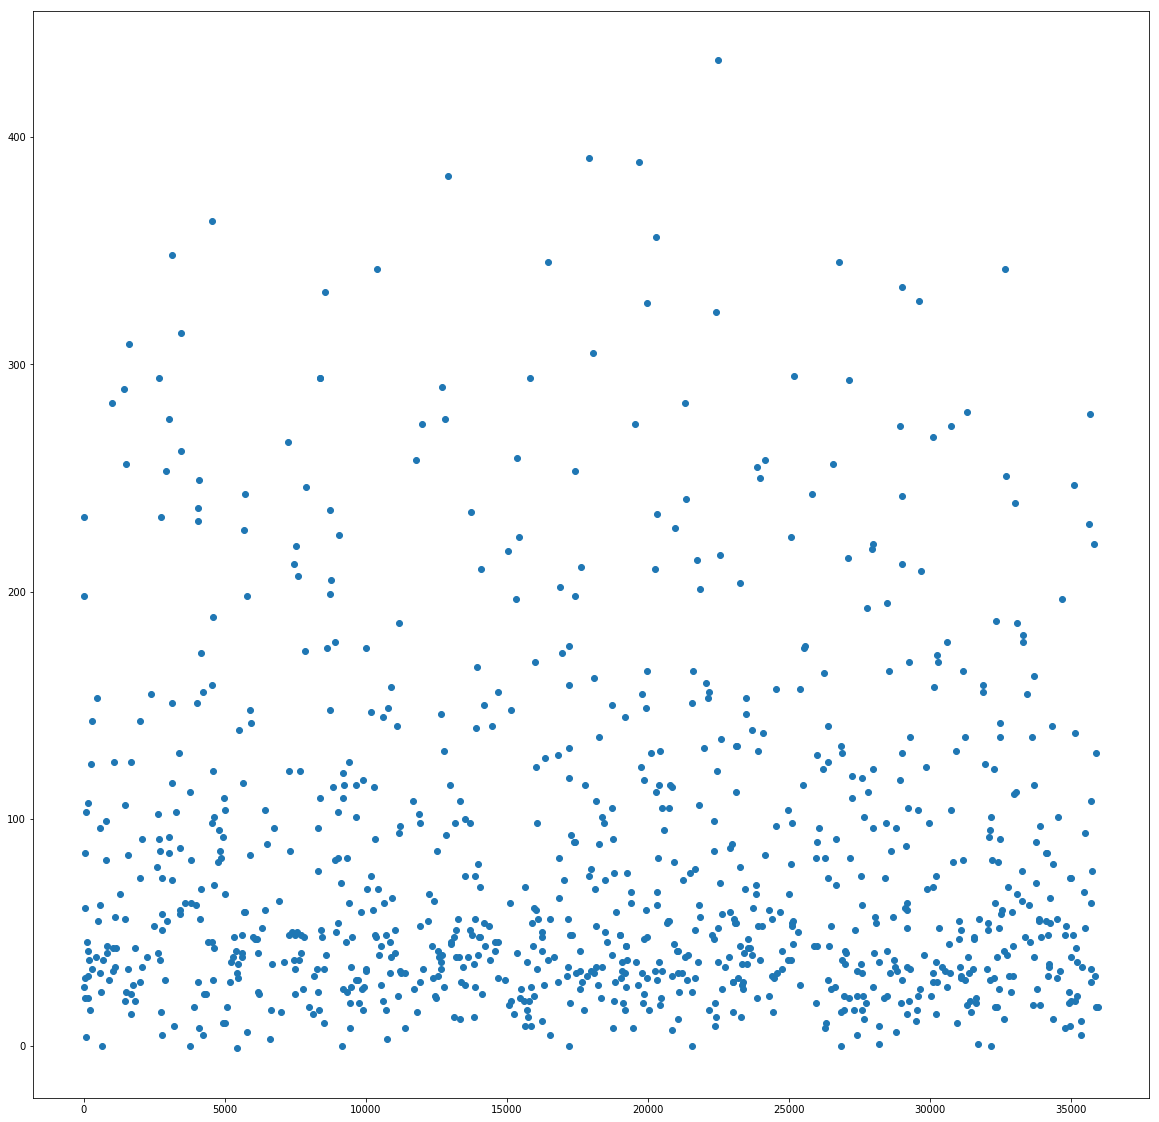

In [120]:
fig, axs = plt.subplots(1, 1, figsize=(20, 20))
axs.scatter(train_answers.itemId, train_answers.Xmin_true)
plt.show()